In [5]:
import mlflow
import mlflow.sklearn
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import time  
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import learning_curve
from sklearn.model_selection import cross_val_score
from mlflow.models.signature import infer_signature
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import (
    accuracy_score, classification_report, confusion_matrix,
    roc_curve, auc, precision_recall_curve
)
mlflow.end_run()


AttributeError: partially initialized module 'mlflow' from '/Users/hoangthuyduongvu/miniconda3/envs/banking-mlops/lib/python3.13/site-packages/mlflow/__init__.py' has no attribute 'version' (most likely due to a circular import)

In [3]:
# Démarrer un nouvel experiment
mlflow.start_run()

# Charger les données
file_path = "../data/Loan_Data_Preprocessed.csv"
df = pd.read_csv(file_path)

NameError: name 'mlflow' is not defined

In [ ]:
#  Séparer les features et la cible
X = df.drop(columns=['customer_id', 'default'])  # Exclure l'ID client et la cible
y = df['default']

#  Séparation des données en train (80%) et test (20%)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Définir la grille d'hyperparamètres à tester
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [5, 10, 15, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2', None]
}

# Initialisation du modèle Random Forest
rf = RandomForestClassifier(random_state=42)

# GridSearchCV pour optimiser les hyperparamètres
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

# Affichage des meilleurs paramètres
print("Meilleurs hyperparamètres : ", grid_search.best_params_)

# Utiliser le meilleur modèle pour prédire
best_rf = grid_search.best_estimator_
y_pred = best_rf.predict(X_test)

# Calcul des métriques avec le meilleur modèle
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

# Log des résultats
mlflow.log_param("best_params", grid_search.best_params_)
mlflow.log_metric("accuracy", accuracy)
mlflow.log_text(report, "classification_report_optimized.txt")

Fitting 5 folds for each of 324 candidates, totalling 1620 fits
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.5s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   0.6s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; total time=   1.3s
[CV] END max_depth=5, max_features=sqrt, min_samples_leaf=1, min_samples_split=2, n_estimators=200; tot

In [4]:

#  Initialisation du modèle Random Forest avec hyperparamètres optimisés
rf = RandomForestClassifier(
    n_estimators=200,      # Augmenté pour plus de robustesse
    max_depth=10,          # Limité pour éviter l'overfitting
    min_samples_split=2,   # Augmenté pour généralisation
    min_samples_leaf=1,    # Plus de contrainte sur les feuilles
    max_features= None,   
    random_state=42
)

#  Entraînement du modèle
rf.fit(X_train, y_train)

#  Prédictions sur le jeu d'entraînement
y_train_pred = rf.predict(X_train)

#  Prédictions sur le jeu de test
y_test_pred = rf.predict(X_test)



NameError: name 'RandomForestClassifier' is not defined

In [155]:
# Calcul des accuracies
train_accuracy = accuracy_score(y_train, y_train_pred)
test_accuracy = accuracy_score(y_test, y_test_pred)

print(f"Train Accuracy: {train_accuracy}")
print(f"Test Accuracy: {test_accuracy}")

Train Accuracy: 1.0
Test Accuracy: 0.997


In [156]:
# Validation croisée pour évaluer la performance du modèle
cv_scores = cross_val_score(rf, X, y, cv=5, scoring="accuracy")

# Affichage des résultats
print(f"CV Accuracy: {cv_scores.mean()} ± {cv_scores.std()}")

CV Accuracy: 0.9960000000000001 ± 0.0015491933384829608


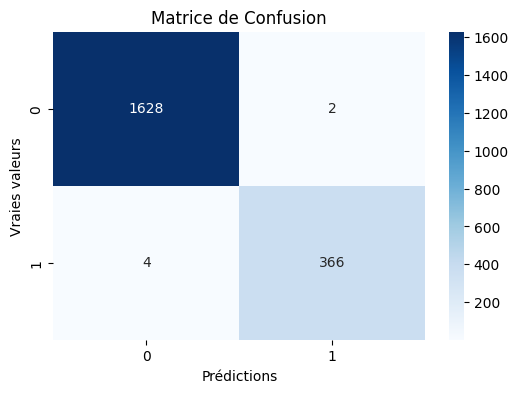

In [157]:

#  Matrice de confusion
cm = confusion_matrix(y_test, y_test_pred)

# Affichage de la matrice de confusion
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Prédictions")
plt.ylabel("Vraies valeurs")
plt.title("Matrice de Confusion")

# Sauvegarde de l'image de la matrice de confusion
plt.savefig("confusion_matrix.png")

# Enregistrement de l'image dans MLflow
mlflow.log_artifact("confusion_matrix.png")

# Affichage de la matrice
plt.show()


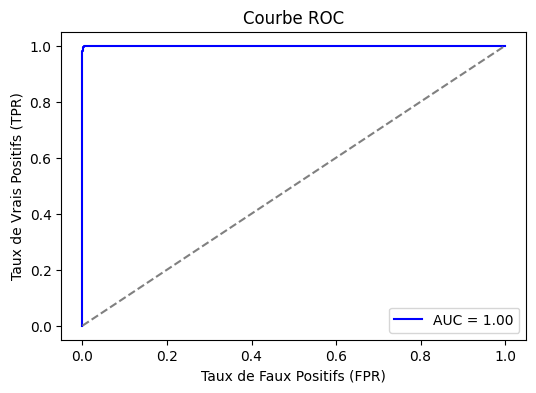

In [158]:
# Prédictions de probabilité pour la classe positive (1)
y_proba = rf.predict_proba(X_test)[:, 1]  # Probabilités pour la classe 1

#  Courbe ROC et AUC
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, color="blue", label=f"AUC = {roc_auc:.2f}")
plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
plt.xlabel("Taux de Faux Positifs (FPR)")
plt.ylabel("Taux de Vrais Positifs (TPR)")
plt.title("Courbe ROC")
plt.legend(loc="lower right")

# Sauvegarde de la courbe ROC
plt.savefig("roc_curve.png")
mlflow.log_artifact("roc_curve.png")  # Enregistrement dans MLflow

plt.show()


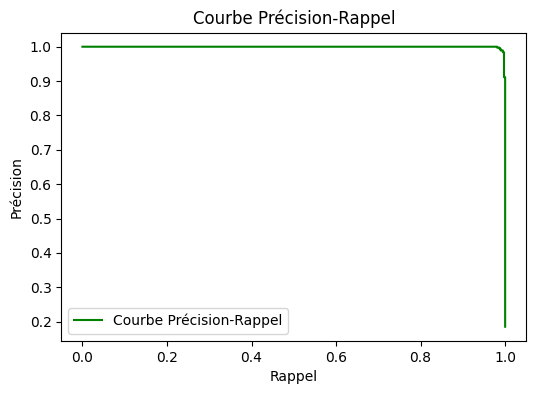

In [159]:
#  Courbe Précision-Rappel
precision, recall, _ = precision_recall_curve(y_test, y_proba)

plt.figure(figsize=(6, 4))
plt.plot(recall, precision, color="green", label="Courbe Précision-Rappel")
plt.xlabel("Rappel")
plt.ylabel("Précision")
plt.title("Courbe Précision-Rappel")
plt.legend(loc="lower left")

plt.savefig("precision_recall_curve.png")
mlflow.log_artifact("precision_recall_curve.png")  
plt.show()

/var/folders/qx/_5n41q4x6hq45m0tg5ts_0cm0000gn/T/ipykernel_35666/2320220191.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis", hue=None)


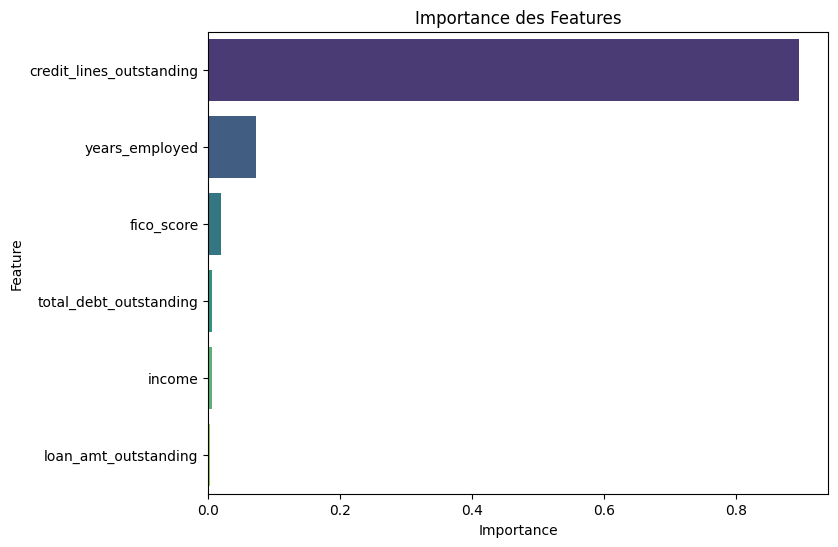

In [160]:
#  Feature Importance
feature_importances = pd.DataFrame({
    "Feature": X.columns,
    "Importance": rf.feature_importances_
}).sort_values(by="Importance", ascending=False)

# Affichage du graphique
plt.figure(figsize=(8, 6))
sns.barplot(x=feature_importances["Importance"], y=feature_importances["Feature"], palette="viridis", hue=None)
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("Importance des Features")

plt.savefig("feature_importances.png")
mlflow.log_artifact("feature_importances.png")
plt.show()


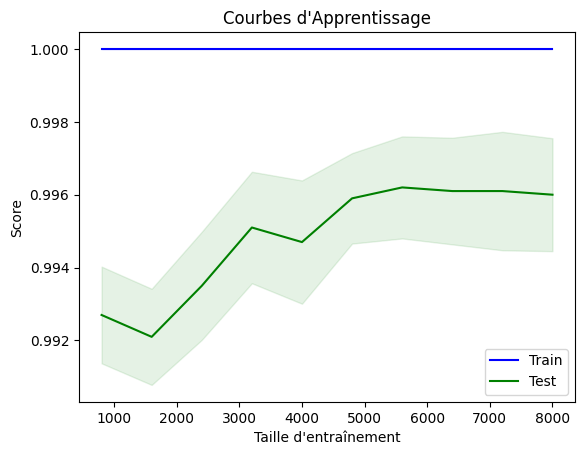

In [161]:
# Obtenir les courbes d'apprentissage
train_sizes, train_scores, test_scores = learning_curve(
    rf, X, y, cv=5, n_jobs=-1, train_sizes=np.linspace(0.1, 1.0, 10)
)

# Calcul des moyennes et écarts-types pour l'affichage
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)

# Affichage des courbes
plt.plot(train_sizes, train_scores_mean, label="Train", color='blue')
plt.plot(train_sizes, test_scores_mean, label="Test", color='green')
plt.fill_between(train_sizes, 
                 train_scores_mean - np.std(train_scores, axis=1),
                 train_scores_mean + np.std(train_scores, axis=1), 
                 alpha=0.1, color='blue')
plt.fill_between(train_sizes, 
                 test_scores_mean - np.std(test_scores, axis=1),
                 test_scores_mean + np.std(test_scores, axis=1), 
                 alpha=0.1, color='green')

plt.xlabel("Taille d'entraînement")
plt.ylabel("Score")
plt.title("Courbes d'Apprentissage")
plt.legend(loc="best")
plt.show()

In [162]:
#  Sauvegarde des features importantes dans un fichier CSV
feature_importances.to_csv("feature_importances.csv", index=False)
mlflow.log_artifact("feature_importances.csv")

#  Inférer la signature du modèle
input_example = X_test.iloc[:1]
signature = infer_signature(X_test, rf.predict(X_test))

#  Log du modèle avec MLflow
mlflow.sklearn.log_model(rf, "random_forest_model", input_example=input_example, signature=signature)

#  Fin de l'exécution
mlflow.end_run()

/opt/anaconda3/envs/lstm_mlflow/lib/python3.13/site-packages/mlflow/types/utils.py:452: UserWarning: Hint: Inferred schema contains integer column(s). Integer columns in Python cannot represent missing values. If your input data contains missing values at inference time, it will be encoded as floats and will cause a schema enforcement error. The best way to avoid this problem is to infer the model schema based on a realistic data sample (training dataset) that includes missing values. Alternatively, you can declare integer columns as doubles (float64) whenever these columns may have missing values. See `Handling Integers With Missing Values <https://www.mlflow.org/docs/latest/models.html#handling-integers-with-missing-values>`_ for more details.
  warnings.warn(
